In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from PIL import Image
import matplotlib.pyplot as plt

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
directory_train = "/content/drive/MyDrive/Colab Notebooks/Data"
train_dataset = image_dataset_from_directory(directory_train, shuffle=True, batch_size=BATCH_SIZE, validation_split=0.2, image_size=IMG_SIZE, subset='training', seed=40)
validation_dataset = image_dataset_from_directory(directory_train, shuffle=True, batch_size=BATCH_SIZE, validation_split=0.2, image_size=IMG_SIZE, subset='validation', seed=40)

Found 6777 files belonging to 6 classes.
Using 5422 files for training.
Found 6777 files belonging to 6 classes.
Using 1355 files for validation.


In [39]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_datatset = validation_dataset.skip(val_batches // 5)

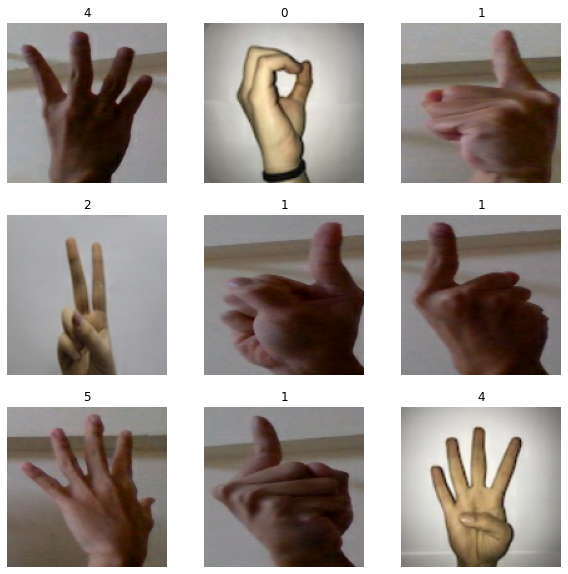

In [40]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [42]:
def data_augmenter():

  data_augmentation = tf.keras.Sequential([
  tfl.experimental.preprocessing.RandomFlip("horizontal"),
  tfl.experimental.preprocessing.RandomRotation(0.2),
  ])

  return data_augmentation

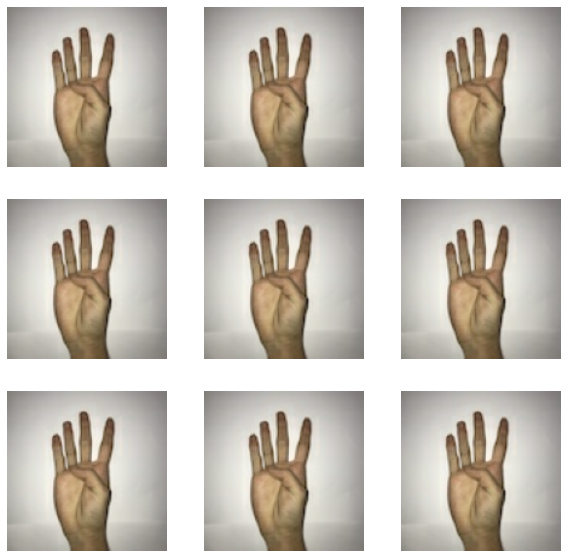

In [43]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [44]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [45]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=True, weights='imagenet')

14536120/14536120 [==============================] - 0s 0us/step


In [46]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [48]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet') 

base_model.trainable = False 

inputs = tf.keras.Input(shape=IMG_SHAPE) 

x = data_augmentation(inputs)

x = preprocess_input(x) 

x = base_model(x, training=False) 

x = tf.keras.layers.GlobalAveragePooling2D()(x) 

x = tfl.Dropout(.2)(x)

outputs = tf.keras.layers.Dense(6)(x)

model1 = tf.keras.Model(inputs, outputs)

In [49]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           

In [50]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [51]:
history1 = model1.fit(train_dataset, validation_data=validation_dataset, epochs=4)

Epoch 1/4
170/170 [==============================] - 787s 5s/step - loss: 0.8568 - accuracy: 0.6761 - val_loss: 0.4044 - val_accuracy: 0.8686
Epoch 2/4
170/170 [==============================] - 108s 631ms/step - loss: 0.4371 - accuracy: 0.8473 - val_loss: 0.2763 - val_accuracy: 0.9173
Epoch 3/4
170/170 [==============================] - 114s 668ms/step - loss: 0.3440 - accuracy: 0.8821 - val_loss: 0.2341 - val_accuracy: 0.9321
Epoch 4/4
170/170 [==============================] - 108s 633ms/step - loss: 0.2824 - accuracy: 0.9041 - val_loss: 0.2337 - val_accuracy: 0.9196


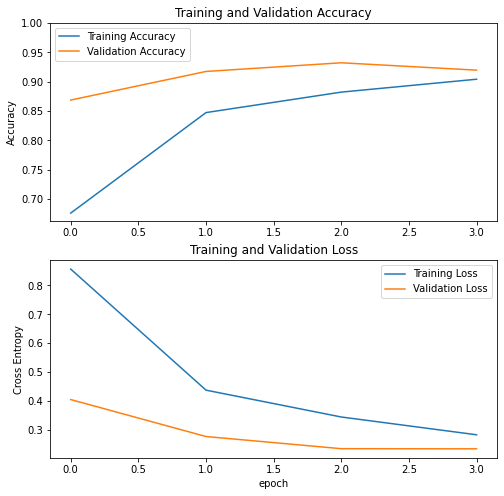

In [52]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [53]:
base_model.trainable = True

In [57]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [58]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           

In [59]:
history2 = model1.fit(train_dataset, validation_data=validation_dataset, epochs=8, initial_epoch=history1.epoch[-1])

Epoch 4/8
170/170 [==============================] - 345s 2s/step - loss: 0.2909 - accuracy: 0.9056 - val_loss: 0.1340 - val_accuracy: 0.9594
Epoch 5/8
170/170 [==============================] - 327s 2s/step - loss: 0.1550 - accuracy: 0.9445 - val_loss: 0.0896 - val_accuracy: 0.9742
Epoch 6/8
170/170 [==============================] - 319s 2s/step - loss: 0.1101 - accuracy: 0.9611 - val_loss: 0.0661 - val_accuracy: 0.9801
Epoch 7/8
170/170 [==============================] - 316s 2s/step - loss: 0.0891 - accuracy: 0.9692 - val_loss: 0.0582 - val_accuracy: 0.9823
Epoch 8/8
170/170 [==============================] - 314s 2s/step - loss: 0.0692 - accuracy: 0.9753 - val_loss: 0.0626 - val_accuracy: 0.9779


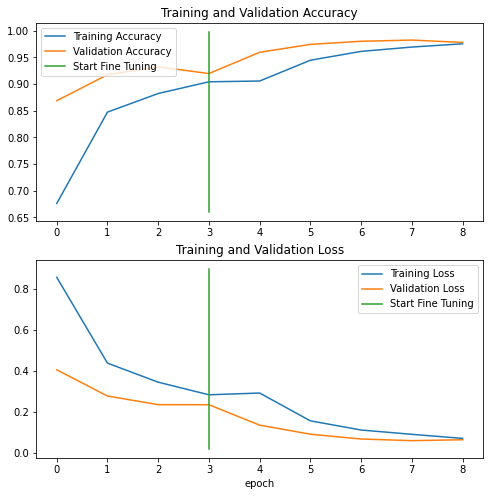

In [60]:
acc += history2.history['accuracy']
val_acc += history2.history['val_accuracy']

loss += history2.history['loss']
val_loss += history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([history1.epoch[-1], history1.epoch[-1]], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([history1.epoch[-1], history1.epoch[-1]], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [70]:
image_batch, label_batch = next(iter(test_dataset))
feature_batch = model1(image_batch)
predictions = tf.math.argmax(tf.nn.softmax(feature_batch, axis=1), axis=1)

In [71]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(label_batch, predictions)
accuracy.result().numpy()

1.0

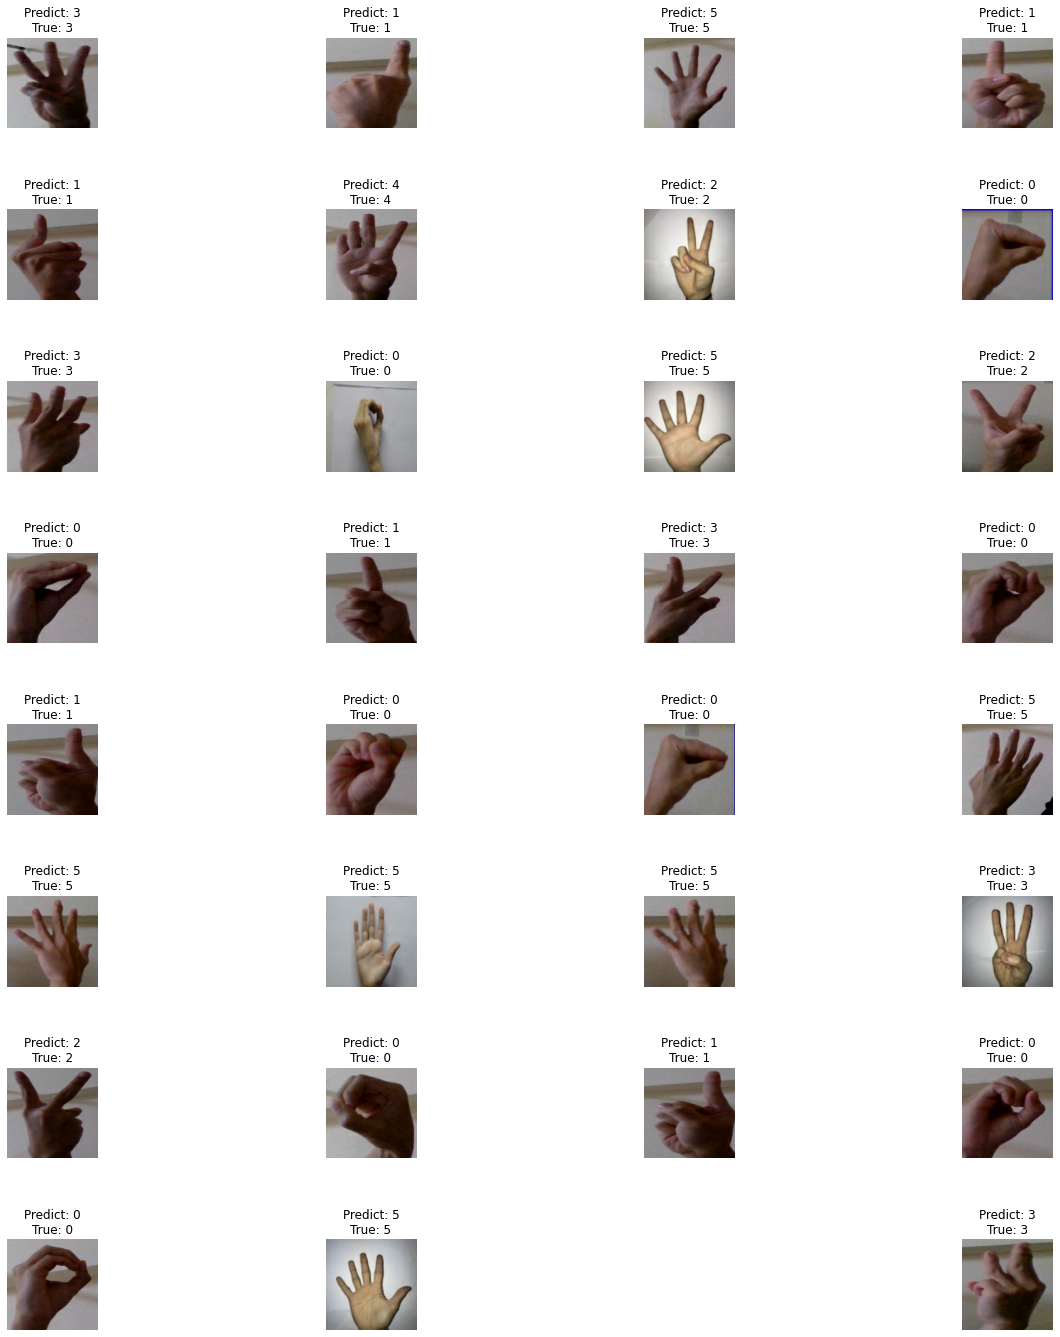

In [72]:
plt.figure(figsize=(20, 20))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.title('Predict: ' + class_names[predictions[i]] + '\nTrue: ' + class_names[label_batch[i]])
  plt.tight_layout(pad=5.0)
  plt.axis("off")

In [73]:
model1.save('/content/drive/MyDrive/Colab Notebooks/parameters.h5')

In [5]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/parameters.h5')

In [69]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           